# Preprocess

In [1]:
import pandas as pd
import  warnings
import numpy as np

warnings.filterwarnings('ignore')

### Read the excel file

In [2]:
df = pd.read_excel('data/Delivery_truck_trip_data.xlsx')

In [3]:
df.head()

,GpsProvider,BookingID,Market/Regular,BookingID_Date,vehicle_no,Origin_Location,Destination_Location,Org_lat_lon,Des_lat_lon,Data_Ping_time,...,TRANSPORTATION_DISTANCE_IN_KM,vehicleType,Minimum_kms_to_be_covered_in_a_day,Driver_Name,Driver_MobileNo,customerID,customerNameCode,supplierID,supplierNameCode,Material Shipped
0,CONSENT TRACK,MVCV0000927/082021,Market,2020-08-17 14:59:01.000,KA590408,"TVSLSL-PUZHAL-HUB,CHENNAI,TAMIL NADU","ASHOK LEYLAND PLANT 1- HOSUR,HOSUR,KARNATAKA","13.1550,80.1960","12.7400,77.8200",2020-08-24 00:05:09,...,320.0,NaN,NaN,NaN,NaN,ALLEXCHE45,Ashok leyland limited,VIJEXHOSR7,VIJAY TRANSPORT,BRACKET / GRAB HANDLE
1,VAMOSYS,VCV00014271/082021,Regular,2020-08-27 16:22:22.827,TN30BC5917,"DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","12.8390,79.9540","12.8390,79.9540",2020-08-28 12:40:28,...,103.0,NaN,NaN,RAMESH,NaN,DMREXCHEUX,Daimler india commercial vehicles pvt lt,VJLEXSHE09,VJ LOGISTICS,ZB MODEL PLATE / 3143
2,CONSENT TRACK,VCV00014382/082021,Regular,2020-08-27 17:59:24.987,TN22AR2748,"LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","11.8710,79.7390","11.8710,79.7390",2020-08-28 09:05:09,...,300.0,NaN,NaN,GIRI,NaN,LUTGCCHE06,Lucas tvs ltd,GSTEXLAK1Q,G.S. TRANSPORT,LETTERING / FUSO
3,VAMOSYS,VCV00014743/082021,Regular,2020-08-28 00:48:24.503,TN28AQ0781,"DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","12.8390,79.9540","12.8390,79.9540",2020-08-28 12:40:31,...,61.0,NaN,NaN,RAVI,NaN,DMREXCHEUX,Daimler india commercial vehicles pvt lt,ARVEXNAM09,ARVINTH TRANSPORT,LU STRUT RA / RADIUS ROD
4,VAMOSYS,VCV00014744/082021,Regular,2020-08-28 01:23:19.243,TN68F1722,"LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","11.8720,79.6320","11.8720,79.6320",2020-08-28 12:40:29,...,240.0,NaN,NaN,TAMIL,NaN,LUTGCCHE06,Lucas tvs ltd,SRTEXKOR96,SR TRANSPORTS,WISHBONE / V ROD/HDT


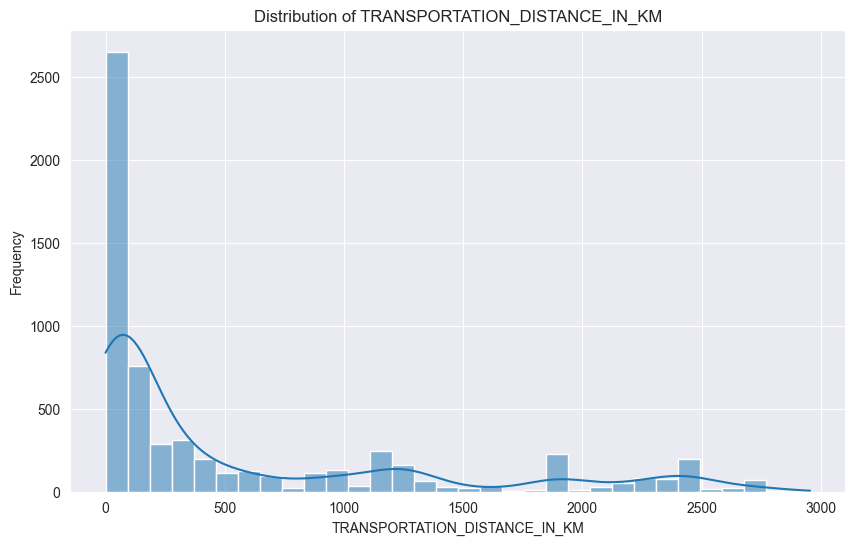

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['TRANSPORTATION_DISTANCE_IN_KM'], kde=True)
plt.title('Distribution of TRANSPORTATION_DISTANCE_IN_KM')
plt.xlabel('TRANSPORTATION_DISTANCE_IN_KM')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [5]:
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
proto = GenericFeatureStatisticsGenerator().ProtoFromDataFrames([{'name': 'test', 'table': df}])

In [6]:
from IPython.core.display import display, HTML
import base64
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="/nbextensions/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

### Numbers of anomalies 

In [7]:
df.ontime.value_counts(dropna=False)

ontime
NaN    4332
G      2548
Name: count, dtype: int64

In [8]:
df.delay.value_counts(dropna=False)

delay
R      4342
NaN    2538
Name: count, dtype: int64

Rows where the value of 'ontime' and the value of 'delay' conflicts are erroneous information. Remove them.

In [9]:
df = df[((df['ontime'] == 'G') & (df['delay'].isna())) | ((df['ontime'].isna()) & (df['delay'] == 'R'))]
df.shape

(6842, 32)

In [10]:
df.ontime.value_counts(dropna=False)

ontime
NaN    4318
G      2524
Name: count, dtype: int64

In [11]:
df.delay.value_counts(dropna=False)

delay
R      4318
NaN    2524
Name: count, dtype: int64

In [12]:
df.loc[df["ontime"] == "G", "ontime"] = 0
df.loc[df["ontime"].isna(), "ontime"] = 1
df.drop('delay', axis=1, inplace= True)

63% (4318/6842) of the orders are delayed (anomalies).

In [13]:
df.rename(columns={"Market/Regular ": "Market/Regular"}, inplace=True)
df['Market/Regular'].value_counts(dropna=False)

Market/Regular
Regular    6773
Market       69
Name: count, dtype: int64

### Drop duplicate/redundant columns

In [14]:
df[df['Destination_Location'] != df['DestinationLocation']]
df.drop('DestinationLocation', axis=1, inplace= True)

Drop rows about driver information, because 50% of the records don't have driver information. Even for those who have, there can be drivers with the same name.

In [15]:
df.drop(["Driver_Name", "Driver_MobileNo"], axis=1, inplace=True)

### Drop names of locations and keep codes of locations

In [16]:
df.drop(["Origin_Location", "Destination_Location", "Current_Location"], axis=1, inplace=True)

### Replace vehicleType, OriginLocation_Code, DestinationLocation_Code value NaN with a categorical value

In [17]:
df.loc[df["vehicleType"].isna(), "vehicleType"] = 'vehicleType'
df.loc[df["OriginLocation_Code"].isna(), "OriginLocation_Code"] = 'OriginLocation_Code'
df.loc[df["DestinationLocation_Code"].isna(), "DestinationLocation_Code"] = 'DestinationLocation_Code'

### Drop name codes of customers/suppliers and keep ID of customers/suppliers

In [18]:
df.drop(["customerNameCode", "supplierNameCode"], axis=1, inplace=True)

If Minimum_kms_to_be_covered_in_a_day is required, it's either 250 or 275. If Minimum_kms_to_be_covered_in_a_day is required, replace it with 250. If not, replace it with 0.

In [19]:
df.loc[df["Minimum_kms_to_be_covered_in_a_day"].isna(), "Minimum_kms_to_be_covered_in_a_day"] = 0
df.loc[df["Minimum_kms_to_be_covered_in_a_day"] > 0, "Minimum_kms_to_be_covered_in_a_day"] = 250
df['Minimum_kms_to_be_covered_in_a_day'].value_counts(dropna=False)

Minimum_kms_to_be_covered_in_a_day
0.0      4054
250.0    2788
Name: count, dtype: int64

Because 'trip_end_date' "cant be considered for calculating delay", drop it.

In [20]:
df.drop('trip_end_date', axis=1, inplace=True)

### Drop BookingID and BookingID_Date and keep trip start date, because transportation is the focus.

In [21]:
df.BookingID.value_counts(dropna=False)

BookingID
MVCV0000798/082021    3
VCV00014072/082021    2
MVCV0000759/082021    2
AEIBK1902026          2
MVCV0000927/082021    1
                     ..
AEIBK2022189          1
AEIBK2023141          1
AEIBK2022871          1
AEIBK2022931          1
WDSBKTP42858          1
Name: count, Length: 6837, dtype: int64

In [22]:
df.drop(['BookingID', 'BookingID_Date'], axis=1, inplace=True)

### In the model, current location and gps information is irrelevant

In [23]:
df.drop(['Curr_lat', 'Curr_lon'], axis=1, inplace=True)
df.drop(['GpsProvider', 'Data_Ping_time'], axis=1, inplace=True)

### Actual ETA can also be dropped, we only need planned ETA and 'ontime'.

In [24]:
df.drop(['actual_eta'], axis=1, inplace=True)

### Break lat_lons into latitudes and longitudes

In [25]:
df[['Org_lat', 'Org_lon']] = df.Org_lat_lon.str.split(',', expand=True)
df[['Des_lat', 'Des_lon']] = df.Des_lat_lon.str.split(',', expand=True)
df.drop(['Org_lat_lon', "Des_lat_lon"], axis=1, inplace=True)

### Get time from datetime

In [26]:
df.Planned_ETA = pd.to_datetime(df.Planned_ETA, format='%Y-%m-%d %H:%M:%S.%f')
df.trip_start_date = pd.to_datetime(df.trip_start_date, format='%Y-%m-%d %H:%M:%S.%f')

In [27]:
from datetime import timedelta

df['trip_time'] = df.Planned_ETA - df.trip_start_date
zero_day = timedelta()
df = df[df['trip_time'] > zero_day]

In [28]:
df

,Market/Regular,vehicle_no,Planned_ETA,ontime,OriginLocation_Code,DestinationLocation_Code,trip_start_date,TRANSPORTATION_DISTANCE_IN_KM,vehicleType,Minimum_kms_to_be_covered_in_a_day,customerID,supplierID,Material Shipped,Org_lat,Org_lon,Des_lat,Des_lon,trip_time
0,Market,KA590408,2020-08-21 18:59:01.000,1,CHEPUZTVSHUA1,HOSHOSALLCCA2,2020-08-17 14:59:01,320.0,vehicleType,0.0,ALLEXCHE45,VIJEXHOSR7,BRACKET / GRAB HANDLE,13.1550,80.1960,12.7400,77.8200,4 days 04:00:00
1,Regular,TN30BC5917,2020-08-31 20:22:22.827,0,CHEORADMRCCB1,CHEMATDMROPA7,2020-08-27 16:21:52,103.0,vehicleType,0.0,DMREXCHEUX,VJLEXSHE09,ZB MODEL PLATE / 3143,12.8390,79.9540,12.8390,79.9540,4 days 04:00:30.827000
2,Regular,TN22AR2748,2020-08-31 21:59:24.987,0,CHEPONLUTCCA4,CHEPONLUTCCA4,2020-08-27 17:57:04,300.0,vehicleType,0.0,LUTGCCHE06,GSTEXLAK1Q,LETTERING / FUSO,11.8710,79.7390,11.8710,79.7390,4 days 04:02:20.987000
3,Regular,TN28AQ0781,2020-09-01 04:48:24.503,0,CHEORADMRCCB1,CHEMATDMROPA7,2020-08-28 00:47:45,61.0,vehicleType,0.0,DMREXCHEUX,ARVEXNAM09,LU STRUT RA / RADIUS ROD,12.8390,79.9540,12.8390,79.9540,4 days 04:00:39.503000
4,Regular,TN68F1722,2020-09-01 05:23:19.243,0,CHENETLUTCCA1,CHENETLUTCCA1,2020-08-28 01:13:48,240.0,vehicleType,0.0,LUTGCCHE06,SRTEXKOR96,WISHBONE / V ROD/HDT,11.8720,79.6320,11.8720,79.6320,4 days 04:09:31.243000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6875,Regular,KA219502,2019-03-27 18:31:00.000,0,V0045771,LE005870,2019-03-27 18:00:00,12.0,25 FT Open Body 21MT,0.0,LTLEXMUM40,55556,TOOL KIT SET,13.007503209603689,77.665098855934886,13.068901840235711,77.590655738806618,0 days 00:31:00
6876,Regular,KA01AE9163,2019-03-31 20:36:00.000,0,V0045771,LE005419,2019-03-31 17:30:00,31.0,40 FT 3XL Trailer 35MT,0.0,LTLEXMUM40,55556,CONTROL LEVER ASSY,13.007503209603689,77.665098855934886,13.196312912801169,77.708156925688726,0 days 03:06:00
6877,Regular,KA01AE9163,2019-03-30 01:38:00.000,0,V0048673,LE005848,2019-03-29 20:44:00,49.0,40 FT 3XL Trailer 35MT,0.0,LTLEXMUM40,55556,SPARE PARTS AUTOMOBILE,16.560192249175344,80.792293091599547,12.722686,77.676518,0 days 04:54:00
6878,Regular,KA21A3643,2019-03-27 17:20:00.000,1,V0048673,LEL04580,2019-03-27 15:29:00,49.0,40 FT 3XL Trailer 35MT,0.0,LTLEXMUM40,55556,SPARE PARTS AUTOMOBILE,16.560192249175344,80.792293091599547,12.896896847817695,77.712223056874862,0 days 01:51:00


In [29]:
def haversine(customer_lng, customer_lat, seller_lng, seller_lat):
    lon1, lat1, lon2, lat2 = map(np.radians, [customer_lng, customer_lat, seller_lng, seller_lat])

    lon = seller_lng - customer_lng
    lat = seller_lat - customer_lat

    r = np.sin(lat / 2.0) ** 2 + np.cos(customer_lat) * np.cos(seller_lat) * np.sin(lon / 2.0) ** 2

    distance = 6371 * 2 * np.arcsin(np.sqrt(r))
    return distance

df['Org_lon'] = pd.to_numeric(df['Org_lon'])
df['Org_lat'] = pd.to_numeric(df['Org_lat'])
df['Des_lon'] = pd.to_numeric(df['Des_lon'])
df['Des_lat'] = pd.to_numeric(df['Des_lat'])
temp = haversine(df['Org_lon'], df['Org_lat'], df['Des_lon'], df['Des_lat'])
df.TRANSPORTATION_DISTANCE_IN_KM.fillna(temp, inplace=True)

In [30]:
df['day'] = df.trip_start_date.dt.day
df['month'] = df.trip_start_date.dt.month
df['year'] = df.trip_start_date.dt.year
df['dayofweek'] = df.trip_start_date.dt.day_of_week
df.drop(['Planned_ETA', "trip_start_date"], axis=1, inplace=True)
df = df[df['year'] > 2000]

In [31]:
df['Market/Regular'] = df['Market/Regular'].astype(str)
df['vehicle_no'] = df['vehicle_no'].astype(str)
df['OriginLocation_Code'] = df['OriginLocation_Code'].astype(str)
df['DestinationLocation_Code'] = df['DestinationLocation_Code'].astype(str)
df['vehicleType'] = df['vehicleType'].astype(str)
df['Minimum_kms_to_be_covered_in_a_day'] = df['Minimum_kms_to_be_covered_in_a_day'].astype(str)
df['customerID'] = df['customerID'].astype(str)
df['supplierID'] = df['supplierID'].astype(str)
df['Material Shipped'] = df['Material Shipped'].astype(str)
df['dayofweek'] = df['dayofweek'].astype(str)
df['trip_time'] = df['trip_time'].dt.total_seconds()
df['ontime'] = df['ontime'].astype('bool')
df.dtypes

Market/Regular                         object
vehicle_no                             object
ontime                                   bool
OriginLocation_Code                    object
DestinationLocation_Code               object
TRANSPORTATION_DISTANCE_IN_KM         float64
vehicleType                            object
Minimum_kms_to_be_covered_in_a_day     object
customerID                             object
supplierID                             object
Material Shipped                       object
Org_lat                               float64
Org_lon                               float64
Des_lat                               float64
Des_lon                               float64
trip_time                             float64
day                                     int32
month                                   int32
year                                    int32
dayofweek                              object
dtype: object

In [32]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
columns = ['Market/Regular', 'vehicle_no', 'OriginLocation_Code', 'DestinationLocation_Code', 'vehicleType', 'Minimum_kms_to_be_covered_in_a_day', 'customerID', 'supplierID', 'Material Shipped', 'dayofweek']
df[columns] = encoder.fit_transform(df[columns])

In [33]:
df.dtypes

Market/Regular                        float64
vehicle_no                            float64
ontime                                   bool
OriginLocation_Code                   float64
DestinationLocation_Code              float64
TRANSPORTATION_DISTANCE_IN_KM         float64
vehicleType                           float64
Minimum_kms_to_be_covered_in_a_day    float64
customerID                            float64
supplierID                            float64
Material Shipped                      float64
Org_lat                               float64
Org_lon                               float64
Des_lat                               float64
Des_lon                               float64
trip_time                             float64
day                                     int32
month                                   int32
year                                    int32
dayofweek                             float64
dtype: object

In [96]:
df.to_csv('temp/Delivery_truck_trip_data_df.csv', index=False)